# HarvestStat Data Profiling - Burkina Faso

In [1]:
import glob, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:32630' # Burkina Faso
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/BF_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
parameters = {
    'format': 'json',
    'country': 'Burkina Faso',
    'product': ['R011','R012','R013','R014','R015','R016','R017','R018','R019'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1984	 | BF1984A1 | 30	| nan	| 0	| nan	| 0	|
| 1997	 | BF1997A1 | 45	| nan	| 0	| nan	| 0	|
| 2001	 | BF2001A1 | 13	| BF2001A2	| 45	| nan	| 0	|
| 2020	 | BF2020A1 | 13	| BF2020A2	| 45	| nan	| 0	|
----------------------------------------------- #


In [3]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# 2. Manual setting
# a) Add admin names to reporting units
admin_level = 'admin_2'
reporting_unit = df.loc[df['fnid'].map(lambda x: x[6] != 'A'), 'fnid'].unique()
df.loc[df.fnid.isin(reporting_unit),admin_level] = df.loc[df.fnid.isin(reporting_unit), 'locality_name'].map(lambda x: x.split(' ')[0])
# ----------------------------------------------- #

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df, area_priority='Area Planted')
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([BF_Admin1_1984, BF_Admin2_2001], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 58,072
Removed 20,094 "Missing Value" points
0/14,518 "Area Harvested" points are retained.
12,765/14,518 "Area Planted" points are retained.
12,664/14,518 "Quantity Produced" points are retained.
12,549/14,518 "Yield" points are retained.
Current data points: 37,978

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1985 - 2022
15 grain types are found: Bambara groundnut, Cotton (Unspecified), Cowpea (unspecified), Fonio, Groundnuts (In Shell), Maize (Corn), Millet, Potato (unspecified), Rice (Paddy), Sesame Seed, Sorghum, Sorghum (Red), Soybean (unspecified), Sweet Potatoes, Yams
2 seasons are found: Main (04-01), Annual (12-01)
4 crop production system are found: All (PS), Plaine/Bas-fond irrigated (PS), Rainfed (PS), Bas-fonds rainfed (PS)
Data sources include:
[1] Institut National de la Statistique et de la Démographie (INSD), Burkina Faso --- Of

- Burkina Faso crop seasonal calendar

![FEWS NET](https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-burkina-faso.png?itok=SHwTf4xi)

- FDW data consists of `BF1984A1` and `BF2001A2`.

| Year  | Admin-1  | # units  | Admin-2  | # units |
| :---: | :----:   | :----:   | :----:   | :---:   |
| 1984  | **`BF1984A1`** | 30 | -        | -       |
| 1997  | BF1997A1 | 45       | -        | -       |
| 2001  | BF2001A1 | 13       | **`BF2001A2`** | 45     |
| 2020  | BF2020A1 | 13       | BF2020A2 | 45     |

- Comparison between admin boundaries.

<img src="../figures/BF_admin_shapes.png"  width="60%">

- In 1997, 15 districts are divided and added.

| 1984-1997|1997-present|
| :---:|:---:|
|BF1984A161 (Bougouriba) | BF2001A21301 (Bougouriba), BF2001A21302 (loba)|
|BF1984A163 (Comoe) | BF2001A20201 (Comoe), BF2001A20202 (Leraba)|
|BF1984A164 (Gourma) | BF2001A20802 (Gourma), BF2001A20803 (Komondjari), BF2001A20804 (Kompienga), BF2001A20402 (Koulpelogo)|
|BF1984A165 (Houet) | BF2001A20901 (Houet), BF2001A20903 (Tuy)|
|BF1984A168 (Kossi) | BF2001A20103 (Kossi), BF2001A20102 (Banwa)|
|BF1984A169 (Mouhoun) | BF2001A20104 (Mouhoun), BF2001A20101 (Bale)|
|BF1984A170 (Oubritenga) | BF2001A21103 (Oubritenga), BF2001A21102 (Kourweogo)|
|BF1984A171 (Poni) | BF2001A21304 (Poni), BF2001A21303 (Noumbiel)|
|BF1984A172 (Seno) | BF2001A21202 (Seno), BF2001A21204 (Yagha)|
|BF1984A173 (Sissili) | BF2001A20603 (Sissili), BF2001A20604 (Ziro)|
|BF1984A174 (Sourou) | BF2001A20106 (Sourou), BF2001A20105 (Nayala)|
|BF1984A175 (Yatenga) | BF2001A21003 (Yatenga), BF2001A21001 (Loroum), BF2001A21004 (Zondoma)|

- In 2001, Admin-1 level became Admin-2 level (no name changes).
- **`BF2001A2`** is used to represent the current admin-level 2 crop data.
- Burkina Faso has a single crop season: `Main (04-01)`, `Annual (12-01)`
- Burkina Faso has no population group(s).

In [4]:
# Define the latest shapefile ------------------- #
latest_level = 2
shape_latest = BF_Admin2_2001.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

BF1984A147:	"Boulkiemde" (FDW) is changed to "Bulkiemde" (shapefile).
BF2001A20601:	"Boulkiemde" (FDW) is changed to "Bulkiemde" (shapefile).


In [5]:
# Link admin boundaries ------------------------- #
link, over = FDW_PD_CreateAdminLink(BF_Admin1_1984, BF_Admin2_2001, 'ADMIN1', 'ADMIN2', prod, epsg)
# Manual Editing
link['BF1984A169'].update(method='PBR')
link['BF1984A155'].update(method='PBR', fnids={'BF2001A20502': {'name': 'Namentenga'}})
link['BF1984A152'].update(method='PBR')
link['BF1984A173'].update(method='PBR', fnids={'BF2001A20603': {'name': 'Sissili'},'BF2001A20604': {'name': 'Ziro'}})
# Crop specific ratios
link_ratio = FDW_PD_RatioAdminLink(link, prod, over, mdx_pss)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=True)
# ----------------------------------------------- #

In [7]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = crop_new.T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Manual change of product name
product_category_custom = {
    'Maize (Corn)':'Maize',
    'Rice (Paddy)':'Rice',
    'Bambara groundnut':'Bambara groundnut',
    'Cowpea (unspecified)': 'Cowpea',
    'Fonio':'Fonio',
    'Groundnuts (In Shell)': 'Groundnuts (In Shell)',
    'Millet':'Millet',
    'Potato (unspecified)': 'Potato',
    'Sesame Seed': 'Sesame Seed',
    'Sorghum':'Sorghum',
    'Sorghum (Red)': 'Sorghum (Red)',
    'Soybean (unspecified)': 'Soybean',
    'Sweet Potatoes': 'Sweet Potatoes',
    'Yams': 'Yams',
}
stack['product'] = stack['product'].replace(product_category_custom)
for f, r in link_ratio.items():
    mdx = pd.MultiIndex.from_frame(r.index.to_frame().reset_index(drop=True).replace(product_category_custom))
    r.index = mdx
    link_ratio[f] = r
# Calibration of crop calendar using External Crop Calendar (ECC)
ecc = pd.read_csv('../data/crop_calendar/external_crop_calendar.csv')
ecc = ecc[ecc['country'] == 'Burkina Faso']
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, ecc, link_ratio)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

# Save data
fn_out = '../data/crop/adm_crop_production_BF.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')
save_npz('../data/crop/adm_crop_production_BF_ratio.npz', link_ratio)

All [season_name, product, crop_production_system] are in the external crop calendar.
../data/crop/adm_crop_production_BF.csv is saved.
../data/crop/adm_crop_production_BF_ratio.npz is saved.


# Visualization of production data

../figures/BF_bar_natgrainprod_Main.png is saved.


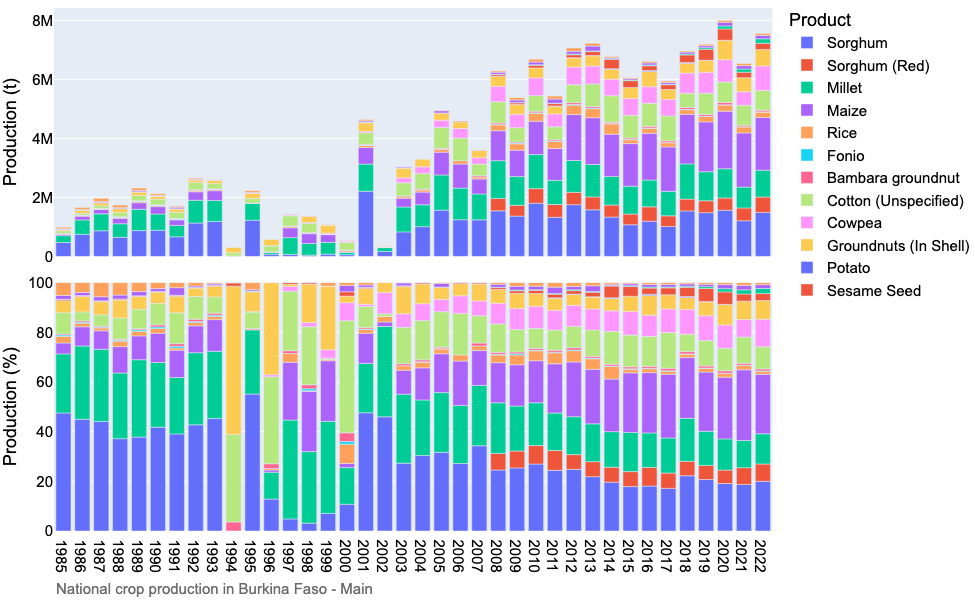

../figures/BF_bar_natgrainprod_Annual.png is saved.


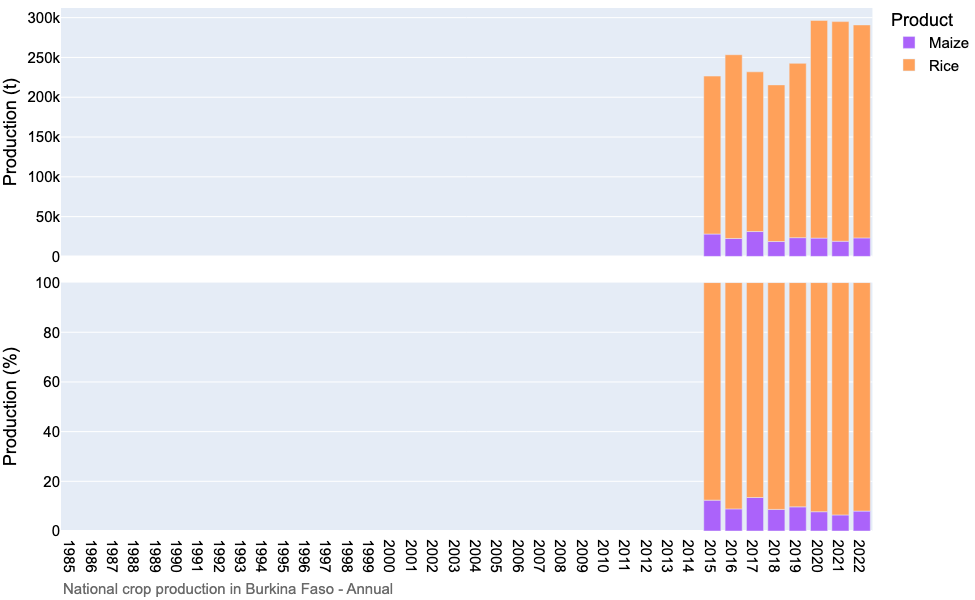

In [10]:
# Bar chart of national crop production
country_iso, country_name = 'BF', 'Burkina Faso'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_order = ['Sorghum','Sorghum (Red)','Millet','Maize','Rice','Fonio']
for season_name in ['Main','Annual']:
    footnote = 'National crop production in %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    fig = PlotBarProduction(sub, year, product_order, footnote, fn_save)
    fig.show()

../figures/BF_line_pay_Maize_Main.png is saved.


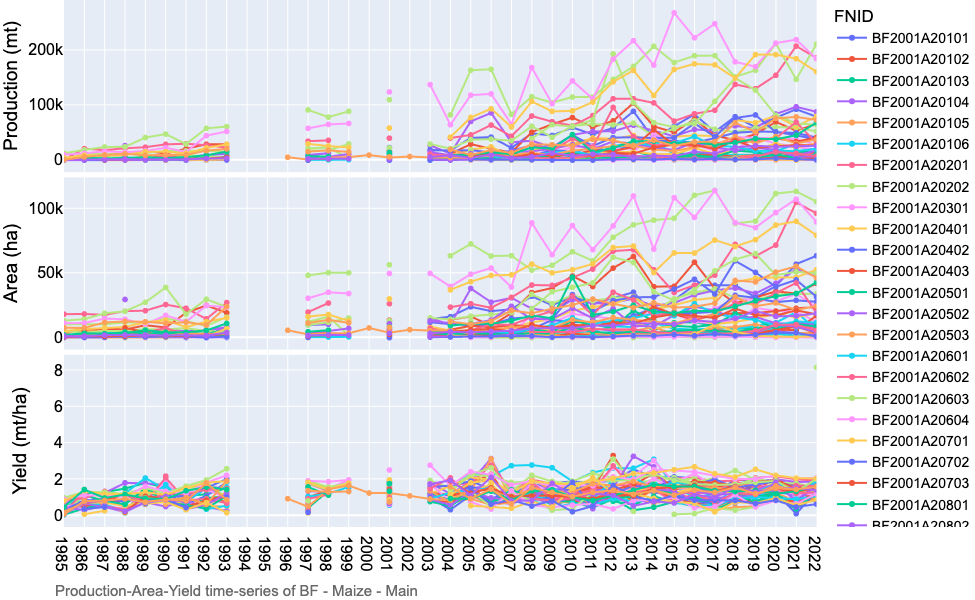

../figures/BF_line_pay_Sorghum_Main.png is saved.


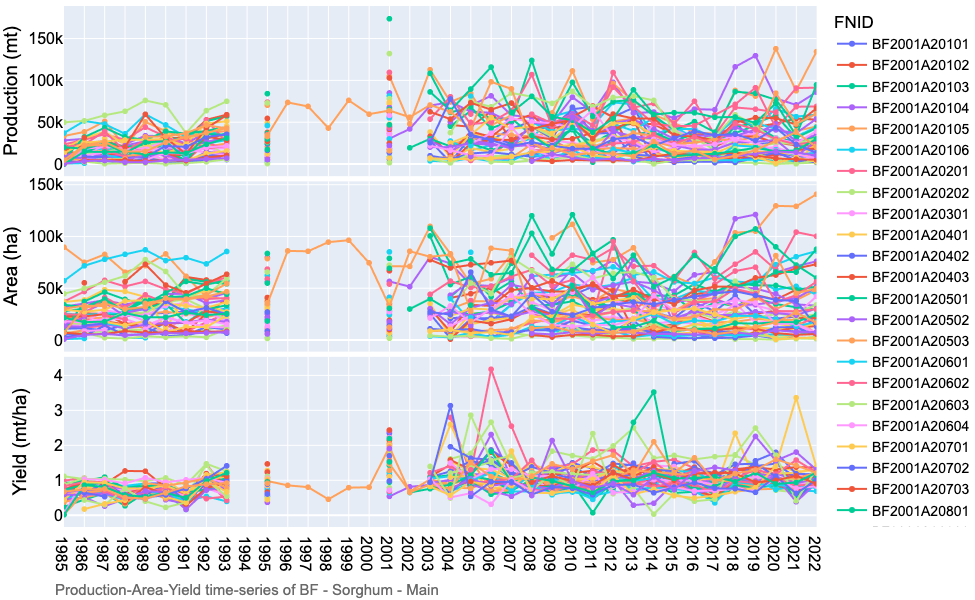

../figures/BF_line_pay_Millet_Main.png is saved.


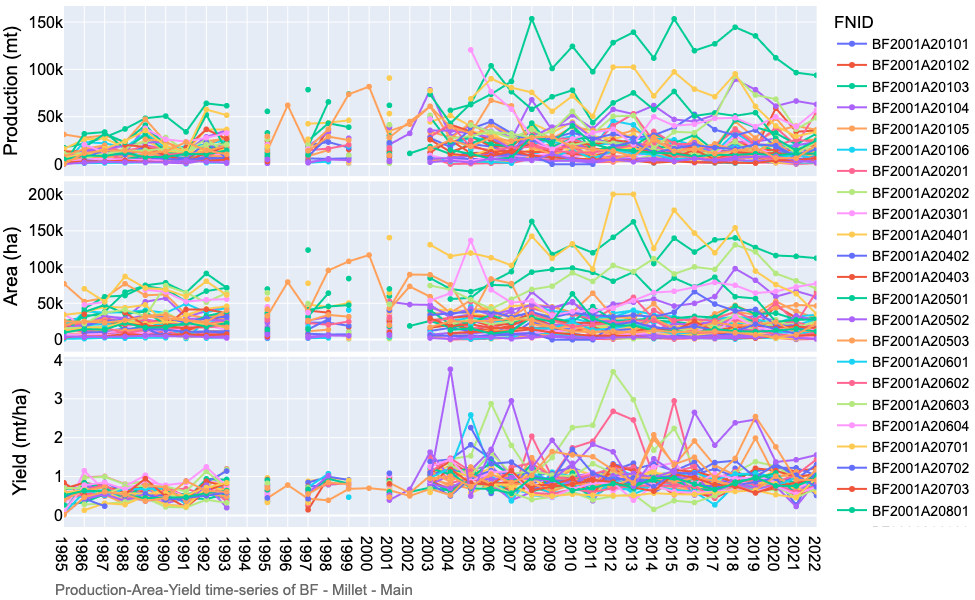

In [11]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'BF', 'Burkina Faso'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Maize','Main'],
    ['Sorghum','Main'],
    ['Millet','Main'],
]
for product_name, season_name in product_season:
    footnote = 'Production-Area-Yield time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    fig = PlotLinePAY(sub, year, footnote, fn_save)
    fig.show()